In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import datetime

import matplotlib.pyplot as plt

from scipy import stats
import math
import random

from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit, train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import  mean_squared_log_error

from xgboost import XGBRegressor

In [42]:
#Global Variables for grid search
n_splits = 3
n_jobs = 3

max_depth_min = 3
max_depth_max = 15
n_estimator_min = 100
n_estimator_max = 200

test_size =0.2
random_state = 1986

In [3]:
train_File = 'train.csv'
test_File = 'test.csv'

df_train = pd.read_csv(train_File)
df_test = pd.read_csv(test_File)
df_test['SalePrice'] = 0
df_concat = pd.concat([df_train,df_test])

In [27]:
df_concat.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
def giveMeWrangledData(df, testFile=False, log=False):
    
    
    df = df.drop(['Id', 'GarageYrBlt','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF'],axis=1)
    
    df['LotFrontage'] =df.LotFrontage.fillna(df.LotFrontage.mode()[0])
    df['MasVnrArea']=df.MasVnrArea.fillna(0.0)
    df['TotalBsmtSF'] = df.TotalBsmtSF.fillna(0)
    df['BsmtFullBath'] = df.BsmtFullBath.fillna(0)
    df['BsmtHalfBath'] = df.BsmtHalfBath.fillna(0)
    df['GarageCars'] = df.GarageCars.fillna(0)
    df['GarageArea'] = df.GarageArea.fillna(0)
    
    #convert data type
    #we are being little lineant to give int64 for YearBuilt, YrSold but those guys are going to be box-coxed 
    #so let them at least enjoy the bigger size for now
    int64_variables = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', \
                     'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', \
                     'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',\
                     'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
                     'PoolArea', 'MiscVal', 'YrSold', 'SalePrice']
    
    #if testFile:
    #    int64_variables.remove('SalePrice')

        
        
        
    
    for c in int64_variables:
        if log:
            print("Changing the data type for :", c)
        #df[c] = df[c].astype(np.int64)
        df[c] = df[c].astype(np.float64)
        
    int_to_categorical_variables = ['MSSubClass', 'OverallQual', 'OverallCond', 'FireplaceQu', 'MoSold']
    for c in int_to_categorical_variables:
        df[c] = df[c].astype(str)
        
    df = df.fillna('NotAvailable')
    return df
df = giveMeWrangledData(df_concat)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450.0,Pave,NotAvailable,Reg,Lvl,AllPub,Inside,...,0.0,NotAvailable,NotAvailable,NotAvailable,0.0,2,2008.0,WD,Normal,208500.0
1,20,RL,80.0,9600.0,Pave,NotAvailable,Reg,Lvl,AllPub,FR2,...,0.0,NotAvailable,NotAvailable,NotAvailable,0.0,5,2007.0,WD,Normal,181500.0
2,60,RL,68.0,11250.0,Pave,NotAvailable,IR1,Lvl,AllPub,Inside,...,0.0,NotAvailable,NotAvailable,NotAvailable,0.0,9,2008.0,WD,Normal,223500.0
3,70,RL,60.0,9550.0,Pave,NotAvailable,IR1,Lvl,AllPub,Corner,...,0.0,NotAvailable,NotAvailable,NotAvailable,0.0,2,2006.0,WD,Abnorml,140000.0
4,60,RL,84.0,14260.0,Pave,NotAvailable,IR1,Lvl,AllPub,FR2,...,0.0,NotAvailable,NotAvailable,NotAvailable,0.0,12,2008.0,WD,Normal,250000.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 76 columns):
MSSubClass       2919 non-null object
MSZoning         2919 non-null object
LotFrontage      2919 non-null float64
LotArea          2919 non-null float64
Street           2919 non-null object
Alley            2919 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2919 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null object
OverallCond      2919 non-null object
YearBuilt        2919 non-null float64
YearRemodAdd     2919 non-null float64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2919 non-null object
Exterior2nd    

In [29]:
def preProcessData(df, log=False):
    
    print("Shape of the data set before pre processing : ", df.shape )

    #get dummies
    if log:
        print("Categorical columns : ", list(df.select_dtypes(exclude=np.number)))
    df = pd.get_dummies(df, dtype=np.float64)
    
    print("\n\nShape of the data set after pre processing : ", df.shape )
    
    if log:
        print("Columns in the data set are : ",list(df))

    return df

df_prep = preProcessData(df)
df_prep.info()

Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Columns: 351 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(351)
memory usage: 7.8 MB


https://stats.stackexchange.com/questions/130262/why-not-log-transform-all-variables-that-are-not-of-main-interest

In [7]:
def newBoxCoxTranformation(df,target,testFile=False, log=False):
    
    #assuming that only numerical features are presented
    print("Shape of the dataset initial : ", df.shape)
    
    if not testFile:
        df =df[df.SalePrice >0]
        print("Shape of the dataset before transformation : ", df.shape)
        y = np.array(df[target].apply( lambda x: math.log(x)))
        X= df.drop(target,axis = 1)
        x_columns = list(X)
        X = preprocessing.MinMaxScaler(feature_range=(1, 2)).fit_transform(X)
        X = pd.DataFrame(X, columns=x_columns)
        
        for c in list(X):
            if len(X[c].unique()) in  [1,2]:
                if log:
                    print("Skipping Transformation for ", c, "because unique values are :",X[c].unique())
            else:
                if log:
                    print("Boxcoxing : ", c)
                X[c] = stats.boxcox(X[c])[0]

        X = X.values
        print("Shape of the dataset after transformation : ", X.shape, y.shape)
        return X,y
    else:
        df = df[df.SalePrice == 0.0]
        print("Shape of the dataset before transformation : ", df.shape)
        X=df.drop(target,axis = 1)
        x_columns = list(X)
        X = preprocessing.MinMaxScaler(feature_range=(1, 2)).fit_transform(X)
        
        X = pd.DataFrame(X, columns=x_columns)
        for c in list(X):
            if len(X[c].unique()) in  [1,2]:
                if log:
                    print("Skipping Transformation for ", c, "because unique values are :",X[c].unique())
            else:
                if log:
                    print("Boxcoxing : ", c)
                X[c] = stats.boxcox(X[c])[0]
        
        
        #X = preprocessing.power_transform( X, method='box-cox')
        X = X.values
        print("Shape of the dataset after transformation : ", X.shape)
        return X
        
    

X = newBoxCoxTranformation(df_prep,'SalePrice',True,False)  
X,y = newBoxCoxTranformation(df_prep,'SalePrice',False,False)

Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350) (1460,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state=random.randint(1,500))#, stratify=df.BldgType)

In [9]:
reg = XGBRegressor()
reg.fit(X_train,y_train)
reg.score(X_test,y_test)

0.8738126748542017

In [10]:
np.sqrt(mean_squared_log_error(y_test, reg.predict(X_test)))

0.010992457249941136

In [11]:
reg.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [12]:
reg

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

##### We need to have different pre-processing logic to test data. We will come back to it little later.

In [13]:
def checkTheTestFile(reg):
    df_test = pd.read_csv(test_File)
    df_test['SalePrice'] = 0.0
    
    df_train =  pd.read_csv(train_File)
    df_concat = pd.concat([df_train,df_test])

    #print(df_test[df_test.TotalBsmtSF.isna()])
    #return
    df = giveMeWrangledData(df_concat,True)
    
    #print(df.info())
    df = preProcessData(df)
    #print(df.info())
    X = newBoxCoxTranformation(df,'SalePrice',True)
    #print(np.sqrt(mean_squared_log_error(y, reg.predict(X))))
    
    df_test['SalePrice'] = np.exp(reg.predict(X))
    
    
    return df_test, X, reg.predict(X)
df_test, X_dummy, y_dummy= checkTheTestFile(reg)

Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)


In [14]:
df_test[['Id','SalePrice']]

,Id,SalePrice
0,1461,125787.546875
1,1462,141982.984375
2,1463,191110.000000
3,1464,200240.312500
4,1465,192861.265625
5,1466,184632.828125
6,1467,169653.500000
7,1468,171752.890625
8,1469,204392.515625
9,1470,138786.703125


In [15]:
df_test[['Id','SalePrice']].to_csv('submission.csv',index=False)

##### I got Kaggle Rank of 2539/4463 with RMSLE =0.14357
##### As on 1/17/2019 : 9:06PM IST
* 0.13501 ==> 2040 
* 0.13252 ==> 1865
* 0.13002 ==> 1704
* 0.12658 ==> 1500
* 0.12351 ==> 1250
* 0.12081 ==> 1000
* 0.11572 ==> 500
* 0.11475 ==> 250
* 0.11310 ==> 100
* 0.10985 ==> 50
* 0.10973 ==> 25
* 0.10845 ==> 10
* 0.08021 ==> 5
* 0.00000 ==> 1

##### Now that I know around what score gets what rank; can we have a function which would what would be testing score ?

##### Logic is to predict first the testing samples. Later use that for training and predict the initial training data set. We would then have actual and predicted SalePrices with which we can calculated the RMSLE.

##### Would this logic work ? let us try for our case now and compare that with Kaggle result....Finger crossed :)

In [16]:
def forCrossValidationStratifiedShuffleSplit(df):
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    print("Number of Splits configured :", sss.get_n_splits(df, df.BldgType))
    
    for train_index, test_index in sss.split(df, df.BldgType):
        yield train_index, test_index
        
    for train_index, test_index in sss.split(df, df.OverallQual):
        yield train_index, test_index

In [ ]:
def doGridSearch():
    
    start_time = datetime.datetime.now()
    
    df_train = pd.read_csv(train_File)
    df_test = pd.read_csv(test_File)
    df_test['SalePrice'] = 0
    df_concat = pd.concat([df_train,df_test])
    
    df = giveMeWrangledData(df_concat)
    df_prep = preProcessData(df)
    
    X,y = newBoxCoxTranformation(df_prep,'SalePrice',False,False)
    
    score_list = []
    for i in range(max_depth_min,max_depth_max):
        #for j in range(n_estimator_min,n_estimator_max,100):
        for bytree in [0.25, 0.5, 0.75,1]:
            for bylevel in [0.25, 0.5, 0.75,1]:
                for lrate in [.01, .025, 0.05, .075, .1, .25, .5]:
                    j=100
                    loop_start = datetime.datetime.now()

                    #reg = XGBRegressor(max_depth=i, n_estimators=j)
                    reg=XGBRegressor(max_depth=i, 
                         n_estimator=j,
                         colsample_bylevel=bylevel,
                         colsample_bytree=bytree,
                         learning_rate=lrate,
                         n_jobs=n_jobs
                        )

                    #cv = ShuffleSplit(n_splits=20, test_size=random.randint(7,9)/10, random_state=random.randint(1,1000))
                    #cv = ShuffleSplit(n_splits=20, test_size=.5, random_state=1986)
                    #print(datetime.datetime())
                    cross_cv = cross_val_score(reg, X, y,\
                                               cv=forCrossValidationStratifiedShuffleSplit(df_train), \
                                               #cv=cv, \
                                               scoring='neg_mean_squared_log_error',n_jobs=n_jobs)
                    print(" Validat Median Score : ", np.sqrt(np.median(cross_cv) * -1), \
                          "Average Score : ", np.sqrt(np.average(cross_cv) * -1) )

                    reg.fit(X,y)
                    training_score = np.sqrt(mean_squared_log_error((y), (reg.predict(X))))
                    print("Training Score :", training_score)

                    df_test_new, X_test, y_test = checkTheTestFile(reg)

                    reg.fit(X_test,y_test)
                    testing_score = np.sqrt(mean_squared_log_error((y), (reg.predict(X))))
                    print("Testing Score :", testing_score)
                    print("Scores : ",(training_score, np.sqrt(np.average(cross_cv) * -1), testing_score,i,j,bytree, bylevel, lrate))
                    score_list.append((training_score, np.sqrt(np.average(cross_cv) * -1), testing_score,i,j,bytree, bylevel, lrate))

                    print("Time for max_depth -",i,"n_estimator -",j," is : ", datetime.datetime.now() - loop_start)
    
    print("Total time for GridSearch : ", datetime.datetime.now() - start_time)
    return score_list

score_list = doGridSearch()
#sorted(score_list,key= lambda x:x[0])

Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350) (1460,)
Number of Splits configured : 3


In [44]:
temp_df = pd.DataFrame(score_list,columns=["training_score",
                                           "validation_score",
                                           "testing_score", 
                                           "max_depth",
                                           "n_estimator"
                                          ])

temp_df.to_csv("GridSearchResults-"+str(datetime.datetime.now().date()))
temp_df

,training_score,validation_score,testing_score,max_depth,n_estimator
0,0.097040,0.010668,0.170715,3,100
1,0.081912,0.010361,0.155165,4,100
2,0.067734,0.010342,0.164185,5,100
3,0.057025,0.010357,0.163656,6,100
4,0.044133,0.010546,0.169926,7,100
5,0.037271,0.010374,0.170266,8,100
6,0.030549,0.010476,0.168559,9,100
7,0.023142,0.010486,0.170051,10,100
8,0.018912,0.010505,0.177387,11,100
9,0.014640,0.010592,0.170507,12,100


In [45]:
temp_df[temp_df.testing_score == temp_df.testing_score.min()]

,training_score,validation_score,testing_score,max_depth,n_estimator
1,0.081912,0.010361,0.155165,4,100


In [46]:
temp_df[temp_df.validation_score == temp_df.validation_score.min()]

,training_score,validation_score,testing_score,max_depth,n_estimator
2,0.067734,0.010342,0.164185,5,100


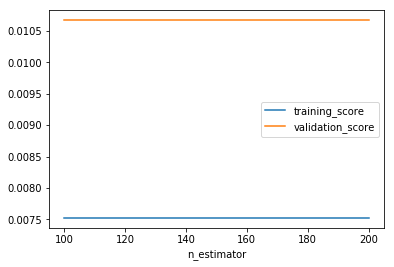

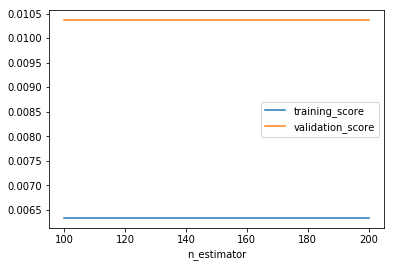

In [21]:
fig, ax = plt.subplots()
ax = temp_df[temp_df.max_depth==3].plot.line('n_estimator','training_score',ax =ax)
ax = temp_df[temp_df.max_depth==3].plot.line('n_estimator','validation_score',ax =ax)
plt.show()
fig, ax = plt.subplots()
ax = temp_df[temp_df.max_depth==4].plot.line('n_estimator','training_score',ax =ax)
ax = temp_df[temp_df.max_depth==4].plot.line('n_estimator','validation_score',ax =ax)
plt.show()
#,'validation_score')

##### Kaggle score remained unchanged, this proves that our logic of test score calculation fails and there must be some value prediction which is huge which brings the average error value up


##### Next Steps:
* re run the grid search and note training score, validation score and testing score. This should not only double check on test score calculation but also gives us the right hyper parameter from the training and validation perspective.
* address the runtime error during scaling or power transform. If boxcox fails attempt a log transformation at least.
* stratify fold testing to check if the training score & validation in the previous exercise still holds goods.
* hyper parameter research for XGBoost
* target variable transformation
* best of best stack approach
* team work stack approach
* XGBoost as the final assesser in best of best stack approach
* XGBoost as the final assesser in the team work starck approach
* 3 layers in stack approach: best of best candidates in the order of their accuracy feeding on input in each case.
* re-assess the dataset

##### The grid search in the kaggle resulted in the different hyper parameter for lowest validation score. Not sure why is that ? validation is through the shuffle split. isnt 3 cross validation set sufficient ?

##### Or it is a game of kfold shuffle split and stratify ?

##### It only makes sense to move on for stacked approach and other hyper parameter tuning if we sort out the cross validation consistency issue. Otherwise, we cannot have the confidence of impact of changes in stacked approaches.

##### The full grid search for split count = 10 is as below. It is evident that 
* testing training score is of no use. We can ignore it in the future grid searches. it would save couple minutes from one grid search.

##### Following are the observation yet to be confirmed:
* Does the testing score confidence is high; post custom stratified split ? We will have predict with the best testing score and see the rank in Kaggle. 6,800 = > 0.15404  & 3,800 ==> 0.16021
* Does we have relation between validation score and testing score ?
* Can we first focus on training score to be 0 with other hyper parameters ? would that be overfitting ? Should we need still learning curve of validation vs testing score.?
* Can we ignore n_estimator and see if the validation score converges with testing score only with max_depth and other hyper parameters?

##### Let us talk about the hyper parameter till we get the gridsearch result

* https://xgboost.readthedocs.io/en/latest/parameter.html
* https://www.kaggle.com/dansbecker/xgboost
* https://www.datacamp.com/community/tutorials/xgboost-in-python

* 1 being the max value, let us have half as the value for {'colsample_bytree':0.5, 'colsample_bylevel':0.5}
* learning_rate = 0.05 because we have already using 0.1 so far. It is suggested in the kaggle blog.
* n_jobs= 2 /4 based on the cpu. I guess Kaggle provides 4 cpu machine. I saw the max cpu spike as 400%
* Surprisingly and unnoticed so far that it does the cross validation by itself. so we can leverage the n_estimator to be 1000 and use early_stopping_rounds for our quick turnaround. So our 2 for loops reduced to one :)


In [22]:
reg

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [23]:
reg = XGBRegressor(max_depth=4, n_estimators=1000, learning_rate = 0.05, n_jobs = 2, colsample_bylevel = 0.5, colsample_bytree = 0.5)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state=random.randint(1,500))
reg.fit(X_train,y_train, early_stopping_rounds=250, eval_metric='rmse',eval_set=[(X_test,y_test)], verbose=100,)

'''my_model = XGBRegressor(n_estimators=1000)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)'''
print()

[0]	validation_0-rmse:10.9591
Will train until validation_0-rmse hasn't improved in 250 rounds.
[100]	validation_0-rmse:0.172251
[200]	validation_0-rmse:0.145651
[300]	validation_0-rmse:0.143314
[400]	validation_0-rmse:0.142121
[500]	validation_0-rmse:0.141962
[600]	validation_0-rmse:0.142049
[700]	validation_0-rmse:0.141985
[800]	validation_0-rmse:0.142001
[900]	validation_0-rmse:0.142063
Stopping. Best iteration:
[738]	validation_0-rmse:0.141901




* 15 ==> validation_0-rmse:0.145474
* 25 ==> [ 527 ]	validation_0-rmse:0.14391
* 100 ==> [567]	validation_0-rmse:0.143869
* 250 ==> [567]	validation_0-rmse:0.143869


* for max_depth = 4
  * [273]	validation_0-rmse:0.148329
  * [729]	validation_0-rmse:0.12575


In [24]:
reg

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=2, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

##### n_estimator we will choose it at the end again through Stratified